# Introduction

In this notebook I try to let a Perceptron - implemented in PyTorch - learn to classify N (e.g. N=5) different patterns that differ only in some small details.

# Generating example data

Here I generate N training patterns that differ only in some small region.

In [12]:
import torch

# 1. define side length of one pattern. pattern are two-dimensional, shape: (S,S)
S = 6

# 2. define how much different base patterns we want to simulate
N_base_patterns = 5

# 3. define how many noisy variants of each base patterns we want to generate
N_training_patterns_per_base_pattern = 100

# 4. compute resulting total number of patterns we will generate
N_total_training_patterns = N_base_patterns * N_training_patterns_per_base_pattern

# 5. prepare data structures to hold input patterns x
# and corresponding one-hot-encoded label vectors y
x = torch.zeros(N_total_training_patterns, S**2)
y = torch.zeros(N_total_training_patterns, N_base_patterns)

# 6. generate desired number of base patterns of shape (2,2)
print(f"Here are all {N_base_patterns} base patterns:")
list_base_patterns = []
for base_pattern_nr in range(N_base_patterns):
    new_base_pattern = torch.randn(2,2) * 0.1
    print(new_base_pattern)
    list_base_patterns.append( new_base_pattern )

# 7. generate training patterns of shape (S,S)
#    where the base pattern of shape (2,2) is in the center of this pattern
print(f"\nHere are some examples of the {N_total_training_patterns} patterns in total:")
pattern_nr = 0
for base_pattern_idx in range(N_base_patterns):
    
    # 7.1 get the next base pattern
    base_pattern = list_base_patterns[base_pattern_idx]
    
    # 7.2 create trainings patterns with the base pattern in the center
    for nr_training_pattern in range(N_training_patterns_per_base_pattern):
        
        # generate random input pattern with defined center values
        #pattern = torch.randn(S, S)
        pattern = torch.rand(S,S)
        pattern[S//2-1:S//2+1, S//2-1:S//2+1 ] = base_pattern
        
        # show the first 3 generated pattern
        if pattern_nr < 3:
            print(pattern)
            #print(pattern.view(S**2))
        
        # store new input pattern
        x[pattern_nr,:] = pattern.view(S**2)
        
        # generate new target pattern
        one_hot_vec = torch.zeros(N_base_patterns)
        one_hot_vec[base_pattern_idx] = 1
                
        # store target pattern
        y[pattern_nr,:] = one_hot_vec
        
        pattern_nr += 1

Here are all 5 base patterns:
tensor([[-0.1969, -0.0649],
        [-0.0267, -0.0380]])
tensor([[-0.0289,  0.1948],
        [ 0.0148,  0.0173]])
tensor([[ 0.1213,  0.0135],
        [-0.2136, -0.1203]])
tensor([[-0.1394,  0.0830],
        [-0.0164,  0.0035]])
tensor([[ 0.1757, -0.0350],
        [ 0.0567, -0.1281]])

Here are some examples of the 500 patterns in total:
tensor([[ 0.8559,  0.9191,  0.0833,  0.4022,  0.4125,  0.6601],
        [ 0.9183,  0.4894,  0.2157,  0.5322,  0.5023,  0.5656],
        [ 0.4306,  0.9159, -0.1969, -0.0649,  0.0809,  0.5040],
        [ 0.5121,  0.1989, -0.0267, -0.0380,  0.3111,  0.4261],
        [ 0.0929,  0.1189,  0.2506,  0.0699,  0.4020,  0.2219],
        [ 0.3706,  0.7563,  0.6316,  0.6568,  0.7487,  0.5180]])
tensor([[ 0.8765,  0.2375,  0.2955,  0.3533,  0.2710,  0.7387],
        [ 0.5770,  0.3328,  0.1846,  0.6230,  0.5827,  0.1521],
        [ 0.0310,  0.8933, -0.1969, -0.0649,  0.0404,  0.4575],
        [ 0.7273,  0.7424, -0.0267, -0.0380,  0.0161, 

In [13]:
x.shape

torch.Size([500, 36])

In [14]:
y.shape

torch.Size([500, 5])

# Shuffle example data

In [15]:
matrix = torch.tensor([[1., 2., 3.],[4., 5., 6.],[7, 8, 9]])
print("Original Matrix:\n", matrix)

Original Matrix:
 tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])


In [16]:
r = torch.tensor([1, 0, 2])

In [17]:
matrix2 = matrix[r, :] # shuffles rows
matrix2

tensor([[4., 5., 6.],
        [1., 2., 3.],
        [7., 8., 9.]])

In [21]:
r = torch.randperm(3)
r

tensor([1, 2, 0])

In [22]:
matrix2 = matrix[r, :] # shuffles rows
matrix2

tensor([[4., 5., 6.],
        [7., 8., 9.],
        [1., 2., 3.]])

In [23]:
r = torch.randperm(N_total_training_patterns)
x = x[r, :]
y = y[r, :]

In [32]:
len(r)

500

In [33]:
r.shape

torch.Size([500])

In [31]:
r

tensor([317, 338, 295, 239, 216, 371, 152, 426, 400, 368, 409, 242, 478, 379,
        108,  56,  44, 110, 363,  29,  58, 218, 196, 294, 134, 270, 285, 354,
        312, 322, 232, 474,  71, 190,  33, 280, 433, 431,  18,  52, 211, 448,
        165, 281,  72, 121, 468, 153, 349,  78, 465,  30, 177, 275, 365, 193,
        486, 106, 267, 286, 325, 101, 450, 422, 120, 355, 374, 344, 103, 407,
         76,  28, 413, 208, 489,  43, 224,  47, 258, 214, 150,  73, 380, 171,
        140,  87,  41,  75, 273, 279,  88, 306, 367, 199, 497, 393, 291, 182,
         70, 411, 463, 406, 301, 315, 432, 227, 207, 244, 204,  67, 217, 160,
        222, 142,  36,  53, 456,  12, 447, 382, 228, 124, 334, 357,  60, 251,
        307,   4, 166, 250,  26, 178, 229, 404, 305, 360, 490, 316, 373, 428,
        435, 151, 321, 383, 392, 284, 391, 376, 170, 445, 100, 366,  16, 439,
          6, 139, 185, 398,  42, 137,  85,  15, 494,  64, 262,  63,  82, 126,
         74, 399, 255, 223, 195, 116, 480, 458,  27, 330, 205, 1

In [24]:
x.shape

torch.Size([500, 36])

In [25]:
y.shape

torch.Size([500, 5])

In [26]:
x[0].view(S,S)

tensor([[ 0.3402,  0.4836,  0.7416,  0.0315,  0.5222,  0.8754],
        [ 0.8635,  0.9094,  0.3935,  0.3115,  0.9259,  0.2883],
        [ 0.5740,  0.7847, -0.1394,  0.0830,  0.0232,  0.0246],
        [ 0.3860,  0.4221, -0.0164,  0.0035,  0.8479,  0.6980],
        [ 0.9930,  0.1471,  0.5036,  0.6709,  0.4968,  0.4362],
        [ 0.8777,  0.0156,  0.3206,  0.2635,  0.2232,  0.8999]])

In [27]:
y[0]

tensor([0., 0., 0., 1., 0.])

In [29]:
x[2].view(S,S)

tensor([[ 0.7279,  0.8880,  0.0660,  0.1948,  0.1768,  0.0015],
        [ 0.9301,  0.5337,  0.0954,  0.1775,  0.4703,  0.0992],
        [ 0.9108,  0.6030,  0.1213,  0.0135,  0.4733,  0.9809],
        [ 0.0406,  0.6602, -0.2136, -0.1203,  0.4293,  0.3796],
        [ 0.1892,  0.1335,  0.7483,  0.2218,  0.3679,  0.0945],
        [ 0.3014,  0.9479,  0.5654,  0.1562,  0.3254,  0.9981]])

In [30]:
y[2]

tensor([0., 0., 1., 0., 0.])

# Split example data intro train and test data

In [34]:
x.shape

torch.Size([500, 36])

In [35]:
y.shape

torch.Size([500, 5])

In [36]:
train_ratio = 0.8
train_N = int(train_ratio * x.shape[0])
train_N

400

In [37]:
x_train = x[:train_N]
y_train = y[:train_N]
x_test  = x[train_N:]
y_test  = y[train_N:]

In [38]:
x_train.shape

torch.Size([400, 36])

In [39]:
y_train.shape

torch.Size([400, 5])

In [40]:
x_test.shape

torch.Size([100, 36])

In [41]:
y_test.shape

torch.Size([100, 5])

In [42]:
x_train.dtype

torch.float32

In [43]:
y_train.dtype

torch.float32

# Perceptron-Klasse

In [44]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# Define a neural net
class MLP(nn.Module):
    def __init__(self, nr_inputs, nr_outputs, use_hidden_layer=False, nr_neurons_hidden1=20):
        super().__init__()
        
        # note: order of generated layers here does not matter!       
        # it is the order of layers in forward() that does matter.
        # see: https://discuss.pytorch.org/t/can-i-change-the-order-of-layers-in-init/105027:
        #
        #  "It doesn’t matter. forward is which defines the real order. 
        #   The only difference is they will be displayed differently 
        #   when you print the model or save it."
        #
        self.use_hidden_layer = use_hidden_layer
        if self.use_hidden_layer:
            self.fc1 = nn.Linear(nr_inputs, nr_neurons_hidden1)
            self.actfunc = torch.nn.ReLU()            
            self.fc2 = nn.Linear(nr_neurons_hidden1, nr_outputs)        
        else:
            self.fc1 = nn.Linear(nr_inputs, nr_outputs)

    def forward(self, input_vec):
        if self.use_hidden_layer:
            x = self.fc1(input_vec)
            x = self.actfunc(x)
            x = self.fc2(x)
        else:
            x = self.fc1(input_vec)
        return x

In [55]:
net = MLP(S**2, N_base_patterns, True)

In [56]:
net

MLP(
  (fc1): Linear(in_features=36, out_features=20, bias=True)
  (actfunc): ReLU()
  (fc2): Linear(in_features=20, out_features=5, bias=True)
)

In [57]:
net.fc1

Linear(in_features=36, out_features=20, bias=True)

In [58]:
net.fc2

Linear(in_features=20, out_features=5, bias=True)

In [59]:
net.fc1.weight.shape

torch.Size([20, 36])

In [60]:
net.fc1.bias.shape

torch.Size([20])

In [61]:
net.fc2.weight.shape

torch.Size([5, 20])

In [62]:
net.fc2.bias.shape

torch.Size([5])

In [63]:
net.fc2.weight

Parameter containing:
tensor([[-1.7823e-01,  9.1667e-02,  2.9252e-02, -1.6461e-01,  1.2583e-01,
          2.3422e-03,  1.2909e-01,  1.1736e-01,  8.2748e-02, -2.2312e-01,
          2.0573e-01,  7.1010e-02,  6.8912e-02,  1.4662e-01,  1.2298e-01,
         -2.0536e-02,  2.1069e-01, -2.7207e-02, -5.2305e-02,  1.1675e-01],
        [ 3.2207e-02, -4.9236e-02, -1.0290e-01, -1.3275e-02, -1.8381e-01,
         -8.5992e-02,  1.3289e-01, -2.1842e-01, -2.0769e-01,  1.6531e-01,
         -6.5349e-02, -1.0767e-01,  9.5822e-02, -8.7097e-02,  6.3408e-02,
         -1.7887e-01,  8.4034e-02, -1.0587e-01,  2.1925e-02,  1.3788e-01],
        [ 7.3056e-03, -2.2278e-01, -1.8547e-01,  6.1399e-03,  1.7675e-01,
         -1.5565e-01, -1.2025e-01, -9.0134e-02,  5.7953e-02, -9.4801e-02,
          6.4420e-02, -9.5703e-03, -8.9502e-02,  8.4784e-02, -1.2935e-01,
          2.0134e-01,  8.0144e-03, -6.2066e-03,  1.5453e-01,  7.5146e-02],
        [ 1.0223e-01, -6.8143e-02, -1.5823e-01, -1.8291e-01,  1.2543e-01,
         -7.3

In [64]:
net = MLP(S**2, N_base_patterns, use_hidden_layer=False)

In [65]:
net

MLP(
  (fc1): Linear(in_features=36, out_features=5, bias=True)
)

In [66]:
net.fc1.weight

Parameter containing:
tensor([[-7.0208e-02,  5.1631e-02, -3.0093e-02,  1.5440e-01, -1.5609e-01,
         -1.1941e-01,  2.9352e-02,  5.7847e-02, -1.5232e-01,  6.4402e-02,
          8.7233e-02,  3.4358e-02, -2.9961e-02, -5.5064e-02,  9.8101e-02,
         -5.7913e-02,  4.4336e-04,  1.3441e-01,  5.2831e-02, -1.3719e-01,
          7.0802e-02,  6.7647e-03, -3.7098e-02, -6.4540e-02, -8.4184e-02,
         -1.4830e-01, -1.4171e-01, -3.2538e-03,  1.5850e-01, -7.6306e-02,
          1.3609e-01,  1.4755e-02,  2.9474e-02, -1.2233e-01, -2.6653e-02,
          1.2485e-01],
        [ 6.5296e-02, -4.1981e-02,  6.2233e-02,  4.0028e-02, -1.2366e-01,
          1.5684e-01, -4.5949e-02,  2.7943e-02, -1.6622e-01,  1.2380e-01,
         -4.3320e-02,  1.8238e-02, -1.5483e-01,  1.2862e-01, -7.4371e-03,
          1.8767e-02, -5.0422e-02, -5.5408e-02, -1.7385e-02,  5.9154e-02,
          1.5031e-01,  1.0001e-02,  4.8698e-02, -8.0781e-02, -2.3165e-02,
         -1.1971e-01,  5.2076e-02,  1.1948e-01,  9.2642e-02,  2.367

In [67]:
net.fc1.bias

Parameter containing:
tensor([-0.1059, -0.1387, -0.1198, -0.0021, -0.1566], requires_grad=True)

# Train MLP to discriminate patterns

MLP(
  (fc1): Linear(in_features=36, out_features=20, bias=True)
  (actfunc): ReLU()
  (fc2): Linear(in_features=20, out_features=5, bias=True)
)
train_step= 0
train_step= 1000
train_step= 2000
train_step= 3000
train_step= 4000
train_step= 5000
train_step= 6000
train_step= 7000
train_step= 8000
train_step= 9000
train_step= 10000
train_step= 11000
train_step= 12000
train_step= 13000
train_step= 14000
train_step= 15000
train_step= 16000
train_step= 17000
train_step= 18000
train_step= 19000


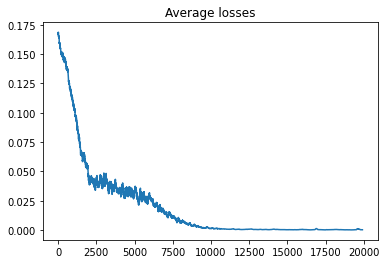

In [68]:
import numpy

# prepare neural network
nr_inputs  = S**2
nr_hidden1 = 20
nr_outputs = N_base_patterns
net = MLP(nr_inputs, nr_outputs, use_hidden_layer=True, nr_neurons_hidden1=nr_hidden1) # MLP
#net = MLP(nr_inputs, nr_outputs, use_hidden_layer=False) # Perceptron
print(net)

# prepare loss and optimizer
#loss_fn = torch.nn.L1Loss()
loss_fn = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

N_train_steps = 20000

losses = []
avg_losses = []
for train_step in range(N_train_steps):   
    
    # 1. get a random training sample
    #    consisting of an input vec and a teacher vec
    random_idx = numpy.random.randint(low=0, high=x_train.shape[0])  
    input_vec   = x_train[random_idx]
    teacher_vec = y_train[random_idx]
    
    # 2. sets gradients to 0 before calculating loss   
    # For: net.zero_grad() vs optim.zero_grad() see:    
    # https://stackoverflow.com/questions/61898668/net-zero-grad-vs-optim-zero-grad-pytorch
    #net.zero_grad()
    optimizer.zero_grad()

    # 3. feed forward step:
    #    here the input vector is used
    output_vec = net( input_vec )

    # 4. compute loss:
    #    here we compare the output vector with the teacher vector, i.e.,
    #    supervised learning happens here
    loss = loss_fn(output_vec, teacher_vec)
    
    # 5. apply this loss backwards thru the network's parameters
    loss.backward() 
    
    # 6. change weights, i.e.
    #    attempt to optimize weights to account for loss/gradients
    optimizer.step() 

    # 7. save loss
    loss_value = loss.detach().numpy()
    losses.append( loss_value )
    if len(losses)>100:
        avg_losses.append( numpy.mean(losses[-100:]) )
    
    # 8 show progress
    if train_step % 1000 == 0:
        print("train_step=", train_step)
        
import matplotlib.pyplot as plt
plt.plot( avg_losses )
plt.title("Average losses")
plt.show()

# Test how good the MLP can discriminate the base patterns

In [69]:
x_test

tensor([[0.3611, 0.5396, 0.6984,  ..., 0.0428, 0.8330, 0.5017],
        [0.9985, 0.4945, 0.4333,  ..., 0.2138, 0.6477, 0.8010],
        [0.6496, 0.8377, 0.8169,  ..., 0.2571, 0.1862, 0.3213],
        ...,
        [0.4416, 0.3548, 0.4010,  ..., 0.7788, 0.4541, 0.9277],
        [0.6689, 0.9211, 0.6596,  ..., 0.7201, 0.8782, 0.3250],
        [0.1469, 0.9608, 0.7949,  ..., 0.1269, 0.5158, 0.3858]])

In [70]:
N_test_patterns = x_test.shape[0]
N_test_patterns

100

In [73]:
correct = 0
for test_pattern_idx in range(N_test_patterns):
    input_vec = x_test[test_pattern_idx]
    #print(input_vec)
    gt        = y_test[test_pattern_idx]
    
    pred = net(input_vec)
    pred_label = torch.argmax( pred )
    gt_label   = torch.argmax( gt )
    
    if test_pattern_idx < 10:
        print()
        print( f"pred={pred}, pred_label={pred_label}" )
        print( f"gt  ={gt},   gt_label  ={gt_label}"   )
    
    if pred_label == gt_label:
        correct += 1
        
CCR = correct/N_test_patterns
print( f"\nClassified {CCR*100}% of the {N_test_patterns} test patterns correctly." ) 


pred=tensor([ 0.0032, -0.0100,  0.0090, -0.0047,  1.0106], grad_fn=<AddBackward0>), pred_label=4
gt  =tensor([0., 0., 0., 0., 1.]),   gt_label  =4

pred=tensor([ 6.6460e-04, -2.4947e-02, -1.1390e-02,  1.0429e+00,  9.7656e-03],
       grad_fn=<AddBackward0>), pred_label=3
gt  =tensor([0., 0., 0., 1., 0.]),   gt_label  =3

pred=tensor([ 0.0021,  0.0053, -0.0053,  0.9835,  0.0064], grad_fn=<AddBackward0>), pred_label=3
gt  =tensor([0., 0., 0., 1., 0.]),   gt_label  =3

pred=tensor([ 3.8142e-04,  9.9417e-01, -4.7536e-03,  2.3718e-03,  5.5532e-03],
       grad_fn=<AddBackward0>), pred_label=1
gt  =tensor([0., 1., 0., 0., 0.]),   gt_label  =1

pred=tensor([-0.0047, -0.0174,  0.0025,  1.0281, -0.0070], grad_fn=<AddBackward0>), pred_label=3
gt  =tensor([0., 0., 0., 1., 0.]),   gt_label  =3

pred=tensor([-0.0028, -0.0078,  1.0023,  0.0173,  0.0030], grad_fn=<AddBackward0>), pred_label=2
gt  =tensor([0., 0., 1., 0., 0.]),   gt_label  =2

pred=tensor([-0.0042,  0.0227, -0.0091, -0.0332,  1.0148]

# Analysing the learned weights

In [74]:
net

MLP(
  (fc1): Linear(in_features=36, out_features=20, bias=True)
  (actfunc): ReLU()
  (fc2): Linear(in_features=20, out_features=5, bias=True)
)

In [75]:
net.fc1.weight.shape

torch.Size([20, 36])

In [77]:
net.fc1.weight[:2]

tensor([[-0.0030, -0.1060, -0.0855,  0.0307, -0.0587, -0.0211, -0.0137, -0.0933,
          0.1216, -0.1279, -0.0401, -0.0156, -0.1780,  0.0277, -0.0036, -0.0780,
          0.0586,  0.0729,  0.0667, -0.0496, -0.0495, -0.1821, -0.0143,  0.0692,
         -0.0777, -0.0650, -0.0841,  0.1376, -0.0393, -0.1148, -0.1263,  0.0202,
         -0.0897, -0.1325, -0.1286,  0.1092],
        [ 0.0475, -0.1187, -0.0672, -0.0670,  0.1186, -0.0898,  0.0665, -0.1617,
          0.0192, -0.1483, -0.1052, -0.1029,  0.0386,  0.0973,  0.0849, -0.0259,
          0.0077,  0.1585,  0.0505,  0.0704,  0.0283,  0.1247,  0.1180,  0.0384,
         -0.1498, -0.0210, -0.0269,  0.1188, -0.0173,  0.0842, -0.1015, -0.0850,
         -0.0757, -0.0828, -0.0033, -0.1180]], grad_fn=<SliceBackward0>)

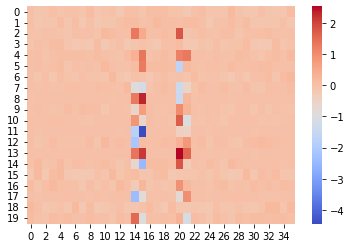

In [79]:
import seaborn
M = net.fc1.weight.detach().numpy()
seaborn.heatmap( M, cmap="coolwarm" )
plt.show()

In [80]:
numpy.arange(0,S**2).reshape(S,S)

array([[ 0,  1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10, 11],
       [12, 13, 14, 15, 16, 17],
       [18, 19, 20, 21, 22, 23],
       [24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35]])

We can see that some of the hidden neurons have learned to strongly weight the center input pixels 14,15,20,21.

Here are also the 20 bias weights:

In [85]:
net.fc1.bias

Parameter containing:
tensor([-0.1779, -0.1464,  0.1530,  0.0591, -0.0037, -0.0952, -0.1381,  0.2217,
        -0.1202,  0.3418, -0.0481, -0.0272,  0.0342, -0.0116,  0.2151, -0.1033,
         0.1703,  0.1443, -0.1453, -0.1362], requires_grad=True)

And what about the output neurons?

In [81]:
net

MLP(
  (fc1): Linear(in_features=36, out_features=20, bias=True)
  (actfunc): ReLU()
  (fc2): Linear(in_features=20, out_features=5, bias=True)
)

In [82]:
net.fc2.weight.shape

torch.Size([5, 20])

In [83]:
net.fc2.weight

Parameter containing:
tensor([[ 0.0329, -0.1537, -0.1126, -0.0860, -0.1605, -0.1008, -0.1704,  0.0930,
          0.0260, -0.0558, -0.0610,  1.1011,  0.0459,  0.3624,  0.1240, -0.1342,
         -0.0285,  0.0853,  0.1663,  0.0278],
        [-0.0927, -0.1852,  0.2009, -0.1213,  0.4487,  0.1944,  0.1809, -0.3625,
          0.3968,  0.1876, -0.0446,  0.7380, -0.0135,  0.7440, -0.3351,  0.1441,
          0.1142, -0.3429, -0.0726, -0.2415],
        [ 0.0851, -0.1340, -0.3852,  0.1197, -0.3106,  0.4400,  0.1327,  0.3623,
          0.4077, -0.2283,  0.0279, -0.1064, -0.1702, -0.1020, -0.2604, -0.0889,
         -0.2102, -0.0927, -0.0877,  0.2063],
        [-0.1919,  0.0631, -0.2256, -0.0695,  0.0326,  0.0312,  0.0909,  0.1217,
         -0.5465,  0.1782,  0.1229, -1.6239,  0.3111, -0.8732,  0.1014, -0.2120,
          0.0952,  0.5825,  0.1916, -0.2896],
        [ 0.0114,  0.0452,  0.4836,  0.0248, -0.1449, -0.4667,  0.0797, -0.0599,
         -0.3277,  0.0358,  0.1163, -0.2223, -0.2046,  0.1147,  0

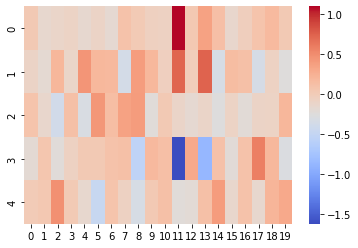

In [84]:
M = net.fc2.weight.detach().numpy()
seaborn.heatmap( M, cmap="coolwarm" )
plt.show()

Here there is no clear weight pattern. The 20 sending neurons have connectionts to the 5 output neurons where sometimes the weights are positive and sometimes the weights are negative.